<a href="https://colab.research.google.com/github/NurikS/BrainAnomalySegmentation/blob/master/BrainSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
os.chdir("../root")
os.mkdir(".kaggle")
os.chdir("../content")

In [0]:
import json
token = {"username":"nurbeks","key":"8f327018630919629002999898de5827"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch import nn
import kaggle

In [6]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 705M/714M [00:16<00:00, 34.8MB/s]
100% 714M/714M [00:16<00:00, 46.3MB/s]


In [7]:
!unzip lgg-mri-segmentation

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_

In [0]:
output_path = '/kaggle/working'

In [0]:
get_y_fn = lambda x: x.parents[0] / (x.stem + '_mask' + x.suffix)

In [0]:
data_path = Path("kaggle_3m")

showing kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif
torch.Size([3, 256, 256])
showing kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif
torch.Size([1, 256, 256])


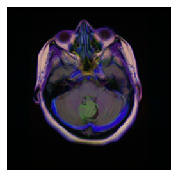

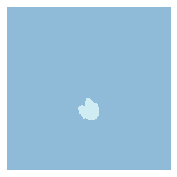

In [11]:
small_data_path = data_path/'TCGA_HT_7680_19970202'
temp_img_file = small_data_path/'TCGA_HT_7680_19970202_6.tif'
temp_mask_file = get_y_fn(temp_img_file)
for f in [temp_img_file, temp_mask_file]:
    print('showing', f)
    if '_mask.tif' in f.name:
        mask = open_mask(f)
        print(mask.shape)
        mask.show()
    else:
        temp_img = open_image(f)
        print(temp_img.shape)
        temp_img.show()



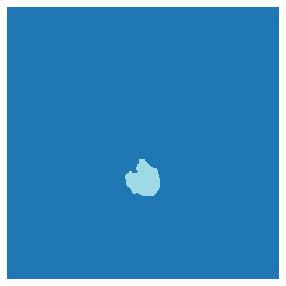

In [12]:
mask = open_mask(get_y_fn(temp_img_file), div=True)
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
validation_folders = [
        'TCGA_HT_7694_19950404', 'TCGA_DU_5874_19950510', 'TCGA_DU_7013_19860523',
        'TCGA_HT_8113_19930809', 'TCGA_DU_6399_19830416', 'TCGA_HT_7684_19950816',
        'TCGA_CS_5395_19981004', 'TCGA_FG_6688_20020215', 'TCGA_DU_8165_19970205',
        'TCGA_DU_7019_19940908', 'TCGA_HT_7855_19951020', 'TCGA_DU_A5TT_19980318',
        'TCGA_DU_7300_19910814', 'TCGA_DU_5871_19941206', 'TCGA_DU_5855_19951217']

In [15]:
# v simple codes; n=nothing to see here, y=area of interest
codes = ['n', 'y']

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs=free//500
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=32, have 16270MB of GPU RAM free


In [0]:
# we need to open the make files with the div=True option - which we can do with a custom label list / item list.
# thanks to https://www.kaggle.com/tanlikesmath/ultrasound-nerve-segmentation-with-fastai/data for showing how this can be done
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

In [0]:
src = (SegmentationItemListWithDiv.from_folder(data_path, recurse=True)
       .filter_by_func(lambda x: not x.name.endswith('_mask.tif'))
       .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=src_size//2, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [19]:
data.train_ds

LabelList (3417 items)
x: SegmentationItemListWithDiv
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelListWithDiv
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: kaggle_3m

In [20]:
data.valid_ds

LabelList (512 items)
x: SegmentationItemListWithDiv
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelListWithDiv
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: kaggle_3m

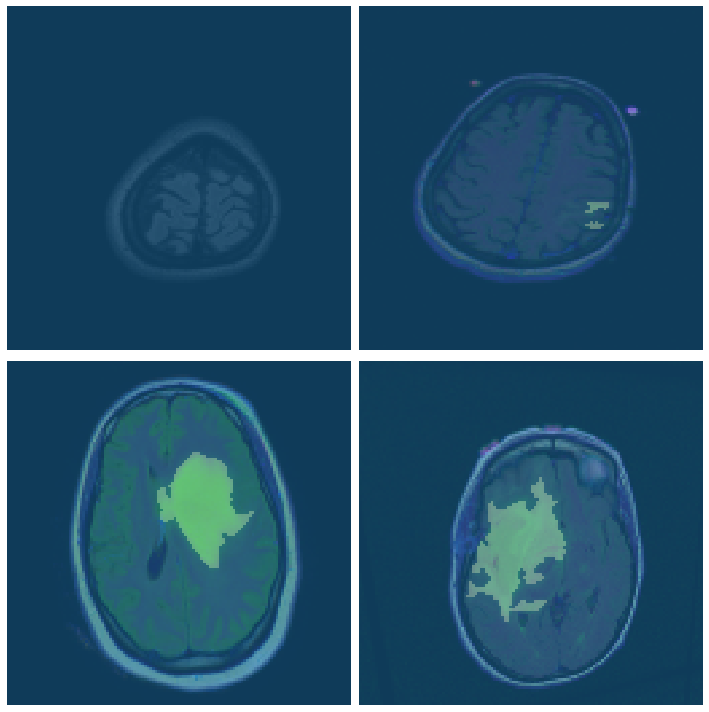

In [21]:
data.show_batch(2, figsize=(10,10))

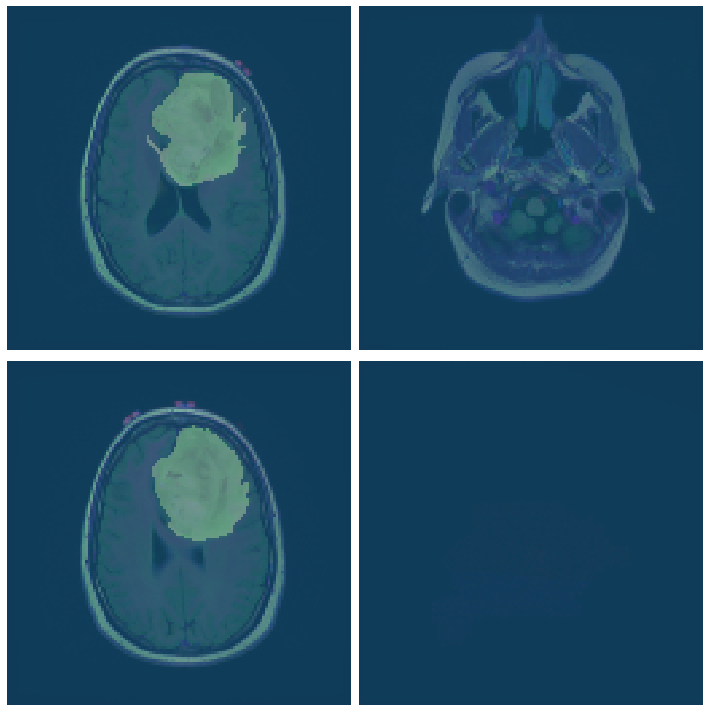

In [22]:
data.show_batch(2, figsize=(10,10), ds_type=DatasetType.Valid)

In [23]:
wd=1e-2
learn = unet_learner(data, models.resnet34, wd=wd, metrics=dice, path=output_path)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-05
Min loss divided by 10: 1.58E-03


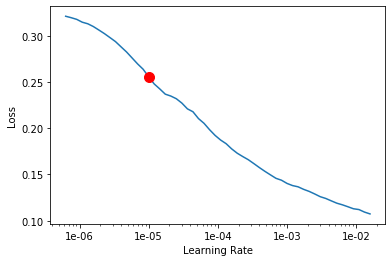

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
lr = 1e-05
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.144559,0.079882,0.000005,00:32
1,0.056580,0.025416,0.546760,00:32
2,0.029541,0.019702,0.757674,00:32
3,0.019964,0.016100,0.736472,00:32


In [0]:
def save_and_show(name):
    saved_to = learn.save(name, return_path=True)
    print('Saved to', saved_to, 'Note: this will be lost unless we commit the kernel')
    learn.load(name) # free memory etc
    learn.show_results(rows=4, figsize=(32, 32))

Saved to /kaggle/working/models/stage-1.pth Note: this will be lost unless we commit the kernel


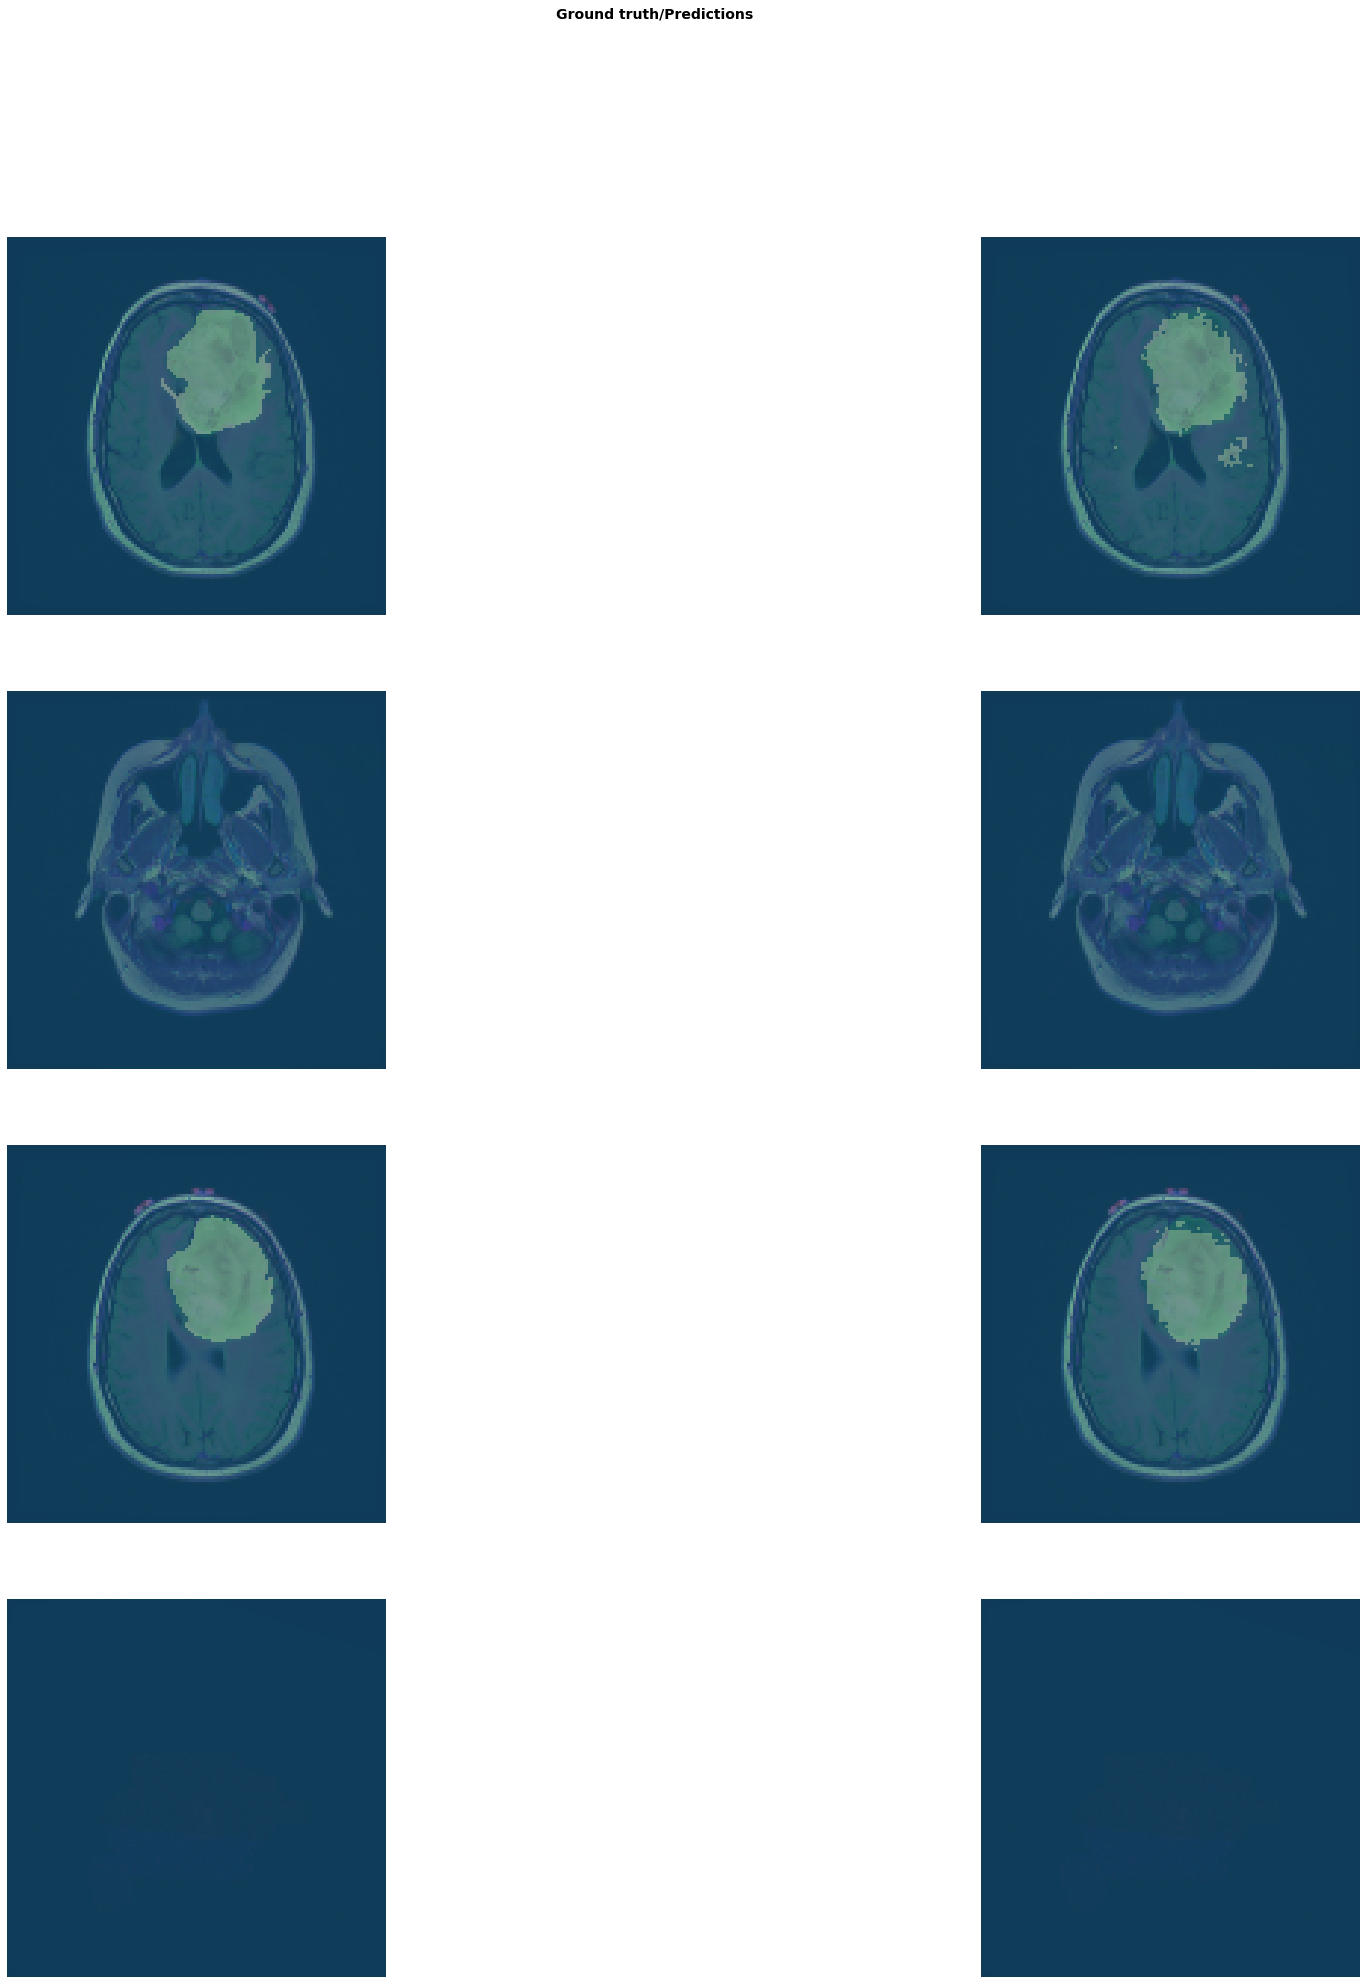

In [28]:
save_and_show('stage-1')

In [29]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(8, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.016968,0.015942,0.741226,00:33
1,0.017500,0.016290,0.747189,00:33
2,0.016510,0.017284,0.755465,00:33
3,0.016436,0.015568,0.737494,00:33
4,0.015267,0.015156,0.755613,00:33
5,0.015061,0.016036,0.768000,00:33
6,0.014582,0.014546,0.758085,00:33
7,0.013736,0.015084,0.772812,00:33


Saved to /kaggle/working/models/stage-2.pth Note: this will be lost unless we commit the kernel


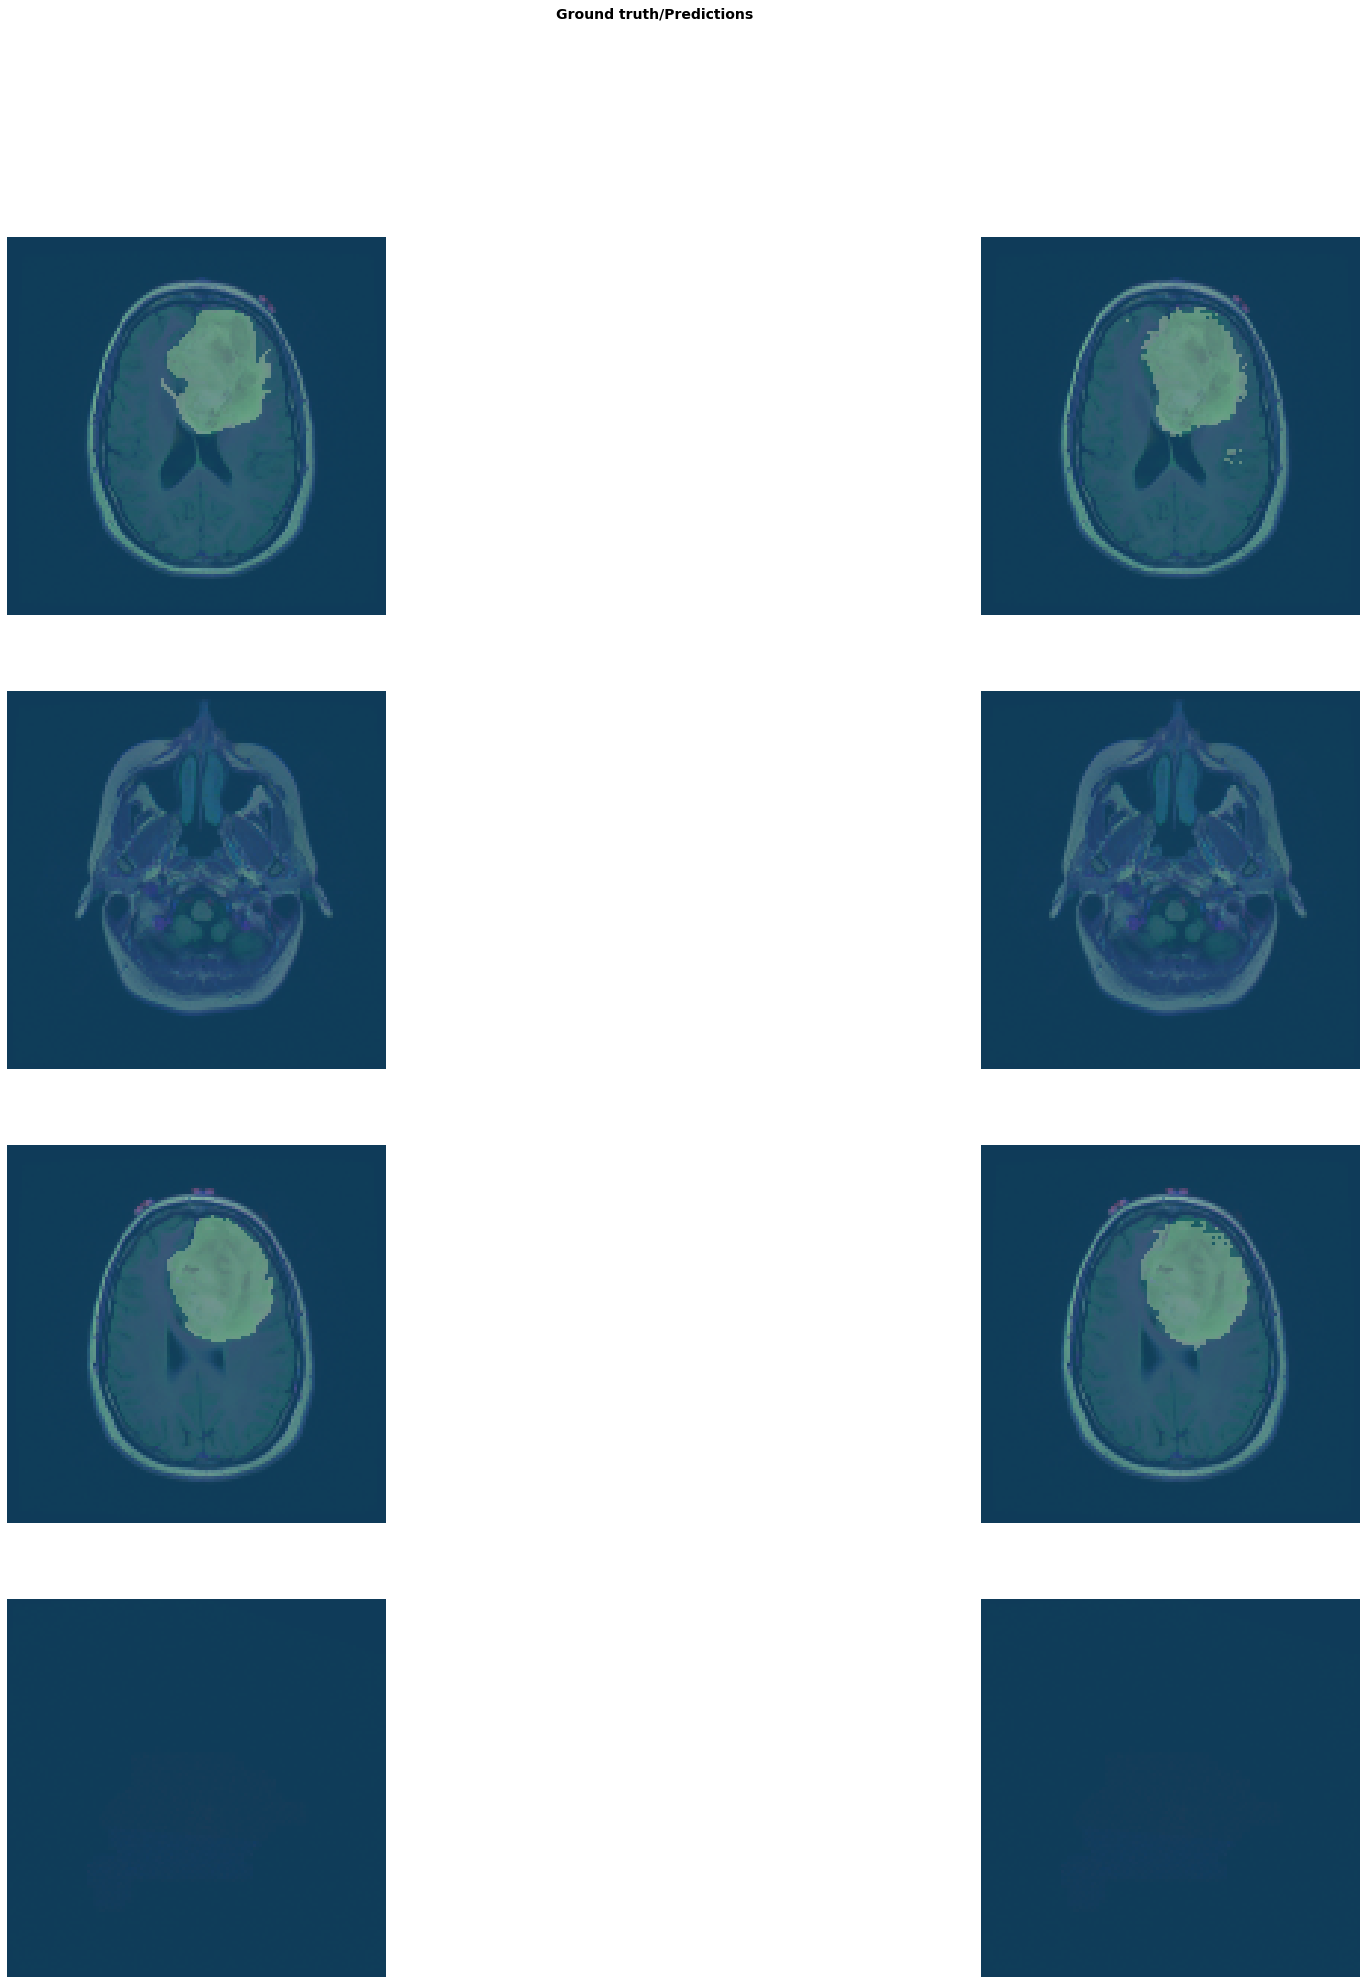

In [30]:
save_and_show('stage-2')

In [0]:
data = (src.transform(get_transforms(), size=src_size, tfm_y=True)
        .databunch(bs=bs//2)
        .normalize(imagenet_stats))